# The ElasticNet results (for the most abundant cell types)

## Outline

The **MLAging - SVZ cell type** workflow consists of sections:

`30 SVZpreprocessing.R` Data preprocessing and preparation in Seurat.

`41 SVZ Cell Type ELN Tuning` ELN model tunning using *non-binarized* and *binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`42 SVZ Cell Type ELN 10x` Run the best ELN model for both binarized and nonbinarized HVGs over 10 random seeds.

`43 SVZ Cell Type ELN Result Viz` Result visulization **this notebook**:

1. [Performance (AUPRC) bar plots](#1.-barplot)
2. [Precision-Recall curve](#2.-prcurve)

`44 SVZ Cell Type Stat` Stat test on whether exercise rejuvenates cells. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

## 1. Performance (AUPRC) bar plots <a name="1.-barplot"></a>

In [2]:
cell_types = ['Mural', 'Astrocyte_qNSC', 'Oligodendro',  'Neuroblast', 'Microglia','aNSC_NPC', 'Endothelial']

for i in cell_types:
    file = open('../results/svz_int2/' + i + '_eln_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [3]:
baseline_df = []
for i in cell_types:
    file = open('../results/svz_int2/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    baseline_df.append(max(y_test.value_counts())/len(y_test))
    file.close()

In [4]:
baseline_df = []
for i in cell_types:
    print(i)
    file = open('../results/svz_int2/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()
    
    file = open('../results/svz_int2/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    
    a = model.predict_proba(X_test)[:,1]
    a = a *0 + 1
    precision, recall, thresholds = precision_recall_curve(y_test, a)
    baseline =  auc(recall, precision)
    print(baseline)
    baseline_df.append(baseline)

Mural
0.7672897196261682
Astrocyte_qNSC
0.7136015325670498
Oligodendro
0.697566371681416
Neuroblast
0.5828402366863905
Microglia
0.7298806314978822
aNSC_NPC
0.5598911070780399
Endothelial
0.7467479674796748


In [18]:
baseline_df = []
for i in cell_types:
    print(i)
    file = open('../results/svz_int2/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()
    
    file = open('../results/svz_int2/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    
    a = model.predict_proba(X_test)[:,1]
    a = a *0 
    precision, recall, thresholds = precision_recall_curve(y_test, a)
    baseline =  auc(recall, precision)
    print(baseline)
    baseline_df.append(baseline)

Mural
0.7672897196261682
Astrocyte_qNSC
0.7136015325670498
Oligodendro
0.697566371681416
Neuroblast
0.5828402366863905
Microglia
0.7298806314978822
aNSC_NPC
0.5598911070780399
Endothelial
0.7467479674796748


In [5]:
df_bar = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'])

for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'], index=range(0, 10))
    df_new['Cell-type'] = i
    df_new['Condition'] = 'Baseline'  
    df_new['AUPRC'] = baseline_df[cell_types.index(i)]
    df_bar = df_bar.append(df_new)

In [6]:
for i in cell_types:
    df_new = pd.DataFrame(columns=['Cell-type', 'Condition', 'AUPRC'], index=range(0, 10))
    df_new['Cell-type'] = i
    df_new['Condition'] = 'ELN test'
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

In [7]:
df_bar

,Cell-type,Condition,AUPRC
0,Mural,Baseline,0.767290
1,Mural,Baseline,0.767290
2,Mural,Baseline,0.767290
3,Mural,Baseline,0.767290
4,Mural,Baseline,0.767290
...,...,...,...
5,Endothelial,ELN test,0.832177
6,Endothelial,ELN test,0.832122
7,Endothelial,ELN test,0.832184
8,Endothelial,ELN test,0.832200


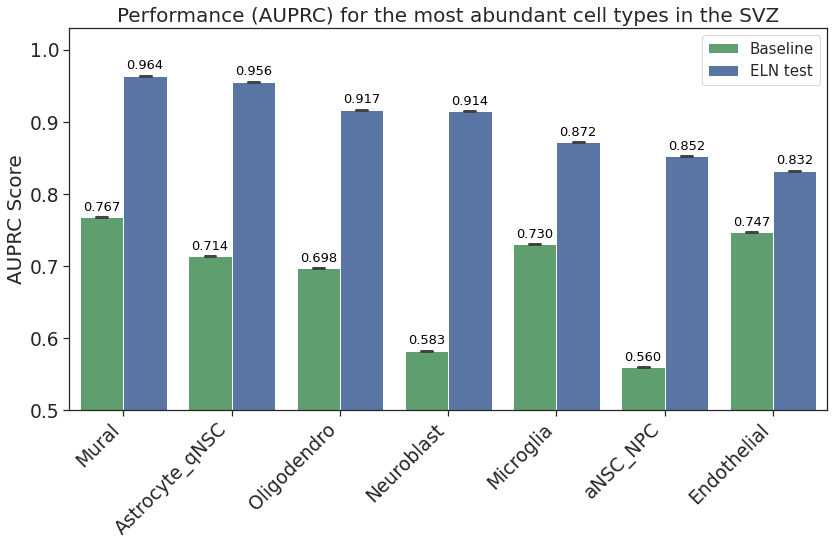

In [8]:
sns.color_palette()

plt.figure(figsize=(12,8))
sns.set(font_scale=1.7, style='ticks')

ax = sns.barplot(data=df_bar, x='Cell-type', y='AUPRC', hue='Condition', ci='sd', capsize=.1, 
                 order=['Mural', 'Astrocyte_qNSC', 'Oligodendro',  'Neuroblast', 'Microglia','aNSC_NPC', 'Endothelial'],
                 palette=[sns.color_palette()[2], sns.color_palette()[0]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.005, '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')

plt.title('Performance (AUPRC) for the most abundant cell types in the SVZ', fontsize=20)
plt.xlabel("", fontsize=20)
plt.ylabel("AUPRC Score", fontsize=20)
plt.ylim(0.5, 1.03)
plt.legend(title='', bbox_to_anchor=(1, 1), fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig('../figures/5C_celltypes_bar_AUPRC_2.pdf')
plt.show()

## 2. Precision-Recall Curve <a name="2.-prcurve"></a>

In [9]:
# for ML models
def calculate_MLPR(ML_model, test_X, test_y):
    y_test_prob = ML_model.predict_proba(test_X)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_test_prob)
    return recall, precision, auc(recall, precision)

In [10]:
for i in cell_types:
    file = open('../results/svz_int2/' + i + '_eln_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    model  = all_10_files[0]
    file.close()
    
    file = open('../results/svz_int2/' + i + '_eln_model_test_sets.save', 'rb')
    final  = pickle.load(file)
    X_test, y_test = final[0]
    file.close()
    locals()[i] = calculate_MLPR(model, X_test, y_test)

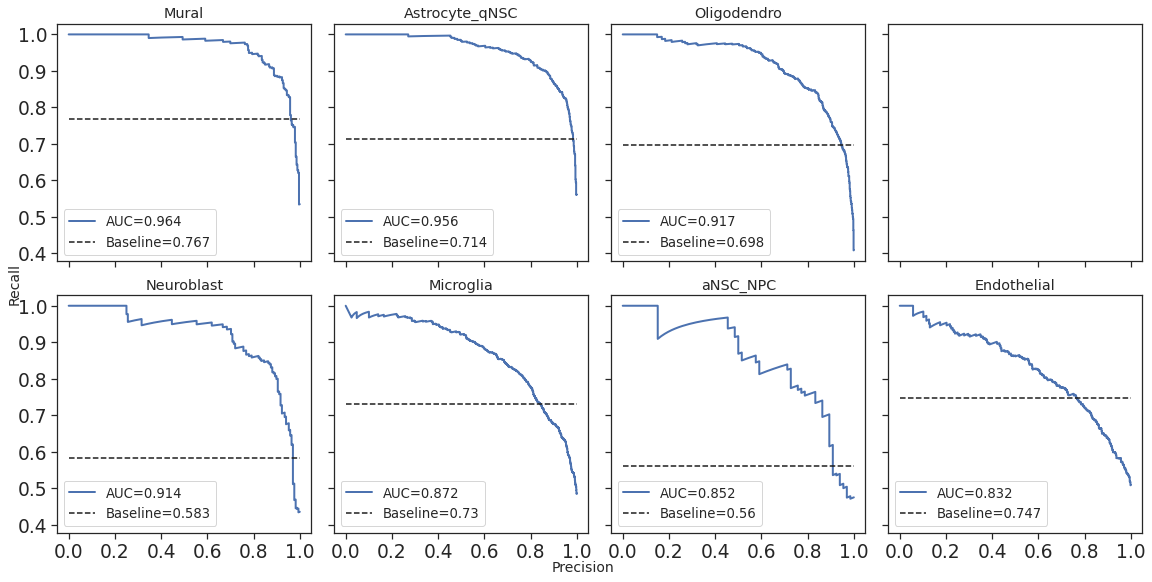

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,8), sharey=True, sharex=True)

sns.set(font_scale=1.2, style='ticks')

# plot the first 3 subplots on the top row
for i in range(3):
    recall, precision, auprc = locals()[cell_types[i]]
    baseline = baseline_df[i]
    
    axs[0,i].plot(recall, precision,
                  label=f'AUC={round(auprc, 3)}',lw=2)
    axs[0,i].plot([0, 1], [baseline, baseline], 'k--' , label=f"Baseline={round(baseline, 3)}")
    
    axs[0,i].set_title(f'{cell_types[i]}')
    axs[0,i].legend(loc='lower left')

# plot the last 4 subplots on the bottom row
for i in range(3,7):
    recall, precision, auprc = locals()[cell_types[i]]
    baseline = baseline_df[i]
    
    axs[1,i-3].plot(recall, precision,
                  label=f'AUC={round(auprc, 3)}',lw=2)
    axs[1,i-3].plot([0, 1], [baseline, baseline], 'k--' , label=f"Baseline={round(baseline, 3)}")
    
    axs[1,i-3].set_title(f'{cell_types[i]}')
    axs[1,i-3].legend(loc='lower left')

# Set axis labels and layout
fig.text(0.5, 0.0, 'Precision', ha='center', fontsize=14)
fig.text(0.0, 0.5, 'Recall', va='center', rotation='vertical', fontsize=14)
plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.savefig('../figures/5D_celltype_auprc_2.pdf')

# Show or save the plot
plt.show()
